In [8]:
import nest
import numpy as np
from matplotlib import pyplot as plt
import brian2 as b2

In [5]:
amplitude = 100.  # Set externally applied current amplitude in pA
dt = 0.1  # simulation step length [ms]

v_min = -100.  # Min membrane potential
v_max = 42.  # Max membrane potential
n_min = 0.1  # Min inactivation variable
n_max = 0.81  # Max inactivation variable
delta_v = 2.  # Membrane potential step length
delta_n = 0.01  # Inactivation variable step length

V_vec = np.arange(v_min, v_max, delta_v)
n_vec = np.arange(n_min, n_max, delta_n)

num_v_steps = len(V_vec)
num_n_steps = len(n_vec)

nest.ResetKernel()
nest.set_verbosity('M_ERROR')
nest.resolution = dt

neuron = nest.Create('hh_psc_alpha')

# Numerically obtain equilibrium state
nest.Simulate(1000)

m_eq = neuron.Act_m
h_eq = neuron.Inact_h

neuron.I_e = amplitude  # Apply external current

# Scan state space
print('Scanning phase space')

V_matrix = np.zeros([num_n_steps, num_v_steps])
n_matrix = np.zeros([num_n_steps, num_v_steps])

# pp_data will contain the phase-plane data as a vector field
pp_data = np.zeros([num_n_steps * num_v_steps, 4])

count = 0
for i, V in enumerate(V_vec):
    for j, n in enumerate(n_vec):
        # Set V_m and n
        neuron.set(V_m=V, Act_n=n, Act_m=m_eq, Inact_h=h_eq)
        # Find state
        V_m = neuron.V_m
        Act_n = neuron.Act_n

        # Simulate a short while
        nest.Simulate(dt)

        # Find difference between new state and old state
        V_m_new = neuron.V_m - V
        Act_n_new = neuron.Act_n - n

        # Store in vector for later analysis
        V_matrix[j, i] = abs(V_m_new)
        n_matrix[j, i] = abs(Act_n_new)
        pp_data[count] = np.array([V_m, Act_n, V_m_new, Act_n_new])

        if count % 10 == 0:
            # Write updated state next to old state
            print('')
            print('Vm:  \t', V_m)
            print('new Vm:\t', V_m_new)
            print('Act_n:', Act_n)
            print('new Act_n:', Act_n_new)

        count += 1

# Set state for AP generation
neuron.set(V_m=-34., Act_n=0.2, Act_m=m_eq, Inact_h=h_eq)

print('')
print('AP-trajectory')
# ap will contain the trace of a single action potential as one possible
# numerical solution in the vector field
ap = np.zeros([1000, 2])
for i in range(1000):
    # Find state
    V_m = neuron.V_m
    Act_n = neuron.Act_n

    if i % 10 == 0:
        # Write new state next to old state
        print('Vm: \t', V_m)
        print('Act_n:', Act_n)
    ap[i] = np.array([V_m, Act_n])

    # Simulate again
    neuron.set(Act_m=m_eq, Inact_h=h_eq)
    nest.Simulate(dt)

Scanning phase space

Vm:  	 -100.0
new Vm:	 1.4727398175805178
Act_n: 0.1
new Act_n: -0.0014210834107191844

Vm:  	 -100.0
new Vm:	 1.5867667913396701
Act_n: 0.19999999999999996
new Act_n: -0.0033687136349885294

Vm:  	 -100.0
new Vm:	 2.073446573665848
Act_n: 0.29999999999999993
new Act_n: -0.005294635541908843

Vm:  	 -100.0
new Vm:	 3.329510306857202
Act_n: 0.3999999999999998
new Act_n: -0.007161856417453705

Vm:  	 -100.0
new Vm:	 5.739746311077141
Act_n: 0.4999999999999998
new Act_n: -0.008913977881446433

Vm:  	 -100.0
new Vm:	 9.402672789697917
Act_n: 0.5999999999999998
new Act_n: -0.010492779851642542

Vm:  	 -100.0
new Vm:	 13.847800735392966
Act_n: 0.6999999999999996
new Act_n: -0.01187528025071627

Vm:  	 -100.0
new Vm:	 18.05247859201522
Act_n: 0.7999999999999996
new Act_n: -0.013110910960761557

Vm:  	 -98.0
new Vm:	 1.4984065110362508
Act_n: 0.18999999999999995
new Act_n: -0.003015645433105535

Vm:  	 -98.0
new Vm:	 1.8936468335068781
Act_n: 0.2899999999999999
new Act_n:


Plot analysis
Searching nullclines
Plotting vector field


Text(0.5, 1.0, 'Phase space of the Hodgkin-Huxley Neuron')

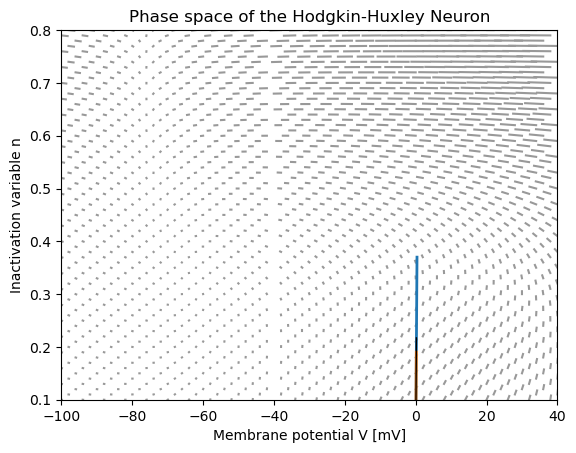

In [6]:

# Make analysis
print('')
print('Plot analysis')

nullcline_V = []
nullcline_n = []

print('Searching nullclines')
for i in range(0, len(V_vec)):
    index = np.nanargmin(V_matrix[:][i])
    if index != 0 and index != len(n_vec):
        nullcline_V.append([V_vec[i], n_vec[index]])

    index = np.nanargmin(n_matrix[:][i])
    if index != 0 and index != len(n_vec):
        nullcline_n.append([V_vec[i], n_vec[index]])

print('Plotting vector field')
factor = 0.1
for i in range(0, np.shape(pp_data)[0], 3):
    plt.plot([pp_data[i][0], pp_data[i][0] + factor * pp_data[i][2]],
             [pp_data[i][1], pp_data[i][1] + factor * pp_data[i][3]],
             color=[0.6, 0.6, 0.6])

plt.plot(nullcline_V[:][0], nullcline_V[:][1], linewidth=2.0)
plt.plot(nullcline_n[:][0], nullcline_n[:][1], linewidth=2.0)

plt.xlim([V_vec[0], V_vec[-1]])
plt.ylim([n_vec[0], n_vec[-1]])

plt.plot(ap[:][0], ap[:][1], color='black', linewidth=1.0)

plt.xlabel('Membrane potential V [mV]')
plt.ylabel('Inactivation variable n')
plt.title('Phase space of the Hodgkin-Huxley Neuron')

Simulating with current I=0 pA
Simulating with current I=20 pA
Simulating with current I=40 pA
Simulating with current I=60 pA
Simulating with current I=80 pA
Simulating with current I=100 pA
Simulating with current I=120 pA
Simulating with current I=140 pA
Simulating with current I=160 pA
Simulating with current I=180 pA
Simulating with current I=200 pA
Simulating with current I=220 pA
Simulating with current I=240 pA
Simulating with current I=260 pA
Simulating with current I=280 pA
Simulating with current I=300 pA
Simulating with current I=320 pA
Simulating with current I=340 pA
Simulating with current I=360 pA
Simulating with current I=380 pA
Simulating with current I=400 pA
Simulating with current I=420 pA
Simulating with current I=440 pA
Simulating with current I=460 pA
Simulating with current I=480 pA
Simulating with current I=500 pA
Simulating with current I=520 pA
Simulating with current I=540 pA
Simulating with current I=560 pA
Simulating with current I=580 pA
Simulating with 

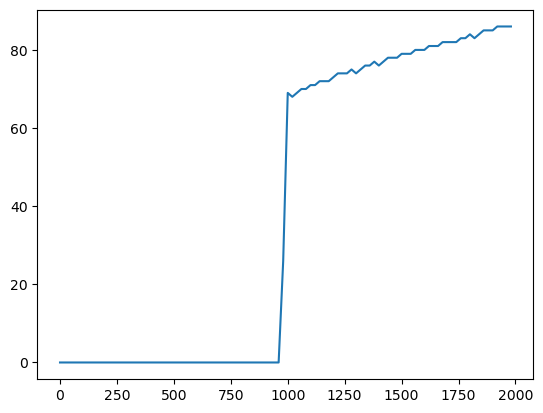

In [7]:
nest.set_verbosity('M_WARNING')
nest.ResetKernel()

simtime = 1000

# Amplitude range, in pA
dcfrom = 0
dcstep = 20
dcto = 2000

h = 0.1  # simulation step size in mS

neuron = nest.Create('hh_psc_alpha')
sr = nest.Create('spike_recorder')

sr.record_to = 'memory'

nest.Connect(neuron, sr, syn_spec={'weight': 1.0, 'delay': h})

# Simulation loop
n_data = int(dcto / float(dcstep))
amplitudes = np.zeros(n_data)
event_freqs = np.zeros(n_data)
for i, amp in enumerate(range(dcfrom, dcto, dcstep)):
    neuron.I_e = float(amp)
    print(f"Simulating with current I={amp} pA")
    nest.Simulate(1000)  # one second warm-up time for equilibrium state
    sr.n_events = 0  # then reset spike counts
    nest.Simulate(simtime)  # another simulation call to record firing rate

    n_events = sr.n_events
    amplitudes[i] = amp
    event_freqs[i] = n_events / (simtime / 1000.)

plt.plot(amplitudes, event_freqs)